<a href="https://colab.research.google.com/github/chrisjulio/INFO7017/blob/main/T4_k_CNN01_Christiano_Guilherme_Marcio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color="#ff9900"> **LSTM**</font>
---

Uma rede <font color="#66ffff"> **LSTM** (*Long short-term memory*)</font> √© composta por unidades LSTM de uma RNN (*Recurrent Neural Network*). Tal unidade, denominada *cell* √© formada tipicamente por uma *input gate*, uma *output gate* e uma *forget gate*. A *cell* √© respons√°vel por "lembrar" valores em intervalos de tempo arbitr√°rios, da√≠ o termo "*memory*" em LSTM. Cada uma das tr√™s *gates* pode ser considerada como um neur√¥nio artificial "convencional", como em uma rede neural multicamada (ou *feedforward*): isto √©, elas calculam uma ativa√ß√£o (usando uma fun√ß√£o de ativa√ß√£o) de uma soma ponderada. Intuitivamente, elas podem ser vistas como reguladores do fluxo de valores que passa pelas conex√µes da LSTM; da√≠ a denomina√ß√£o "*gate*". Existem conex√µes entre tais *gates* e a *cell*, assim as portas controlam os dados de entrada e sa√≠da da c√©lula.

A express√£o "*long short-term*" refere-se ao fato de que LSTM √© um modelo para a **mem√≥ria de curto prazo que pode durar por um longo per√≠odo de tempo**. Um modelo LSTM √© adequado para classificar, processar e prever s√©ries temporais, considerando atrasos temporais de tamanho e dura√ß√£o desconhecidos entre eventos importantes. LSTMs foram desenvolvidos especificamente para lidar com os problemas *exploding gradient* e *vanishing gradient*, presentes no treinamento de RNNs tradicionais.

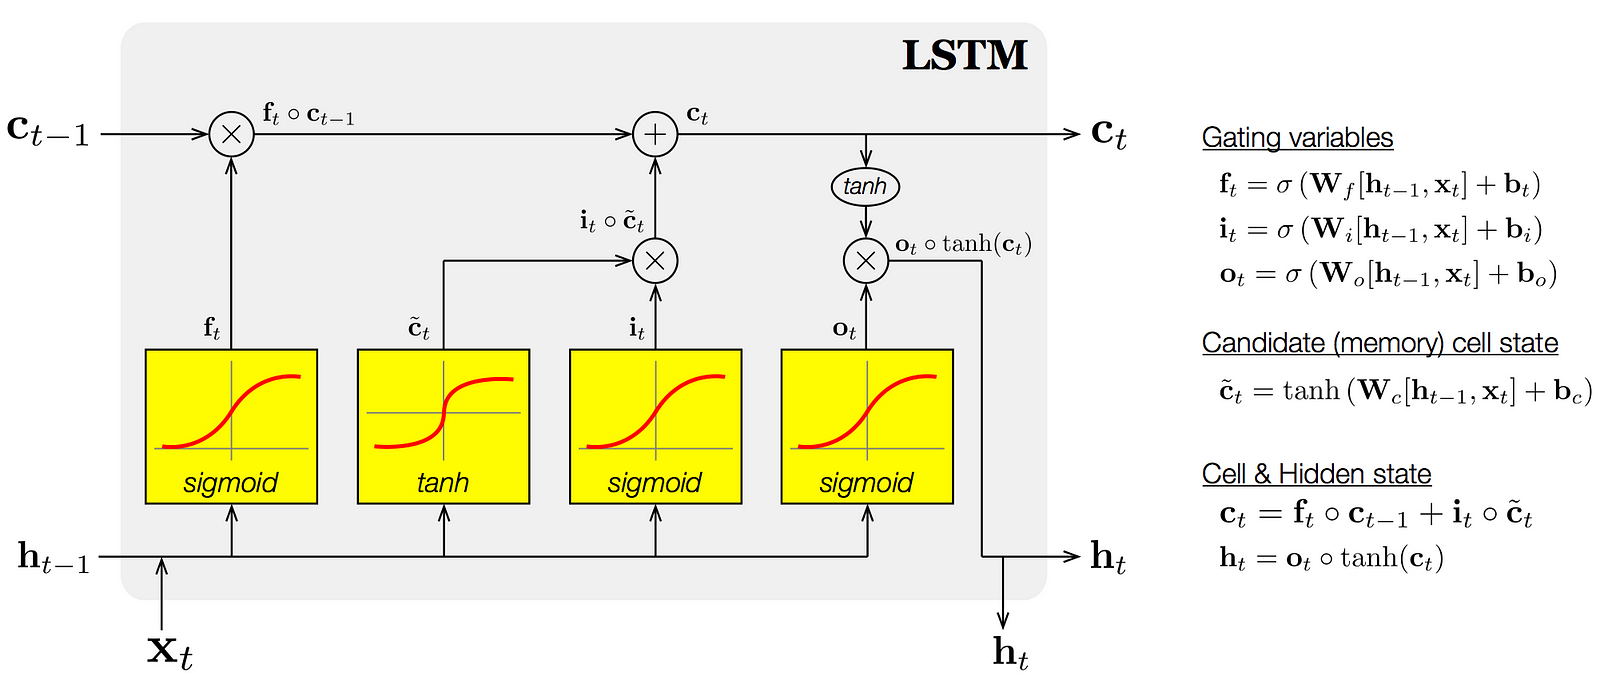

> Componentes de LSTMs

Na arquitetura LSTM convencional, uma c√©lula LSTM (LSTM *cell*) cont√©m os seguintes componentes:

- Forget Gate $f$ (uma NN com $sigmoid$)
- Candidate memory $\tilde{c}$ (uma NN com $tanh$)
- Input Gate $i$ (uma NN com $sigmoid$)
- Output Gate $o$ (uma NN com $sigmoid$)
- Hidden state $h$ (um vetor)
- Memory state $c$ (um vetor)
- Entradas para a LSTM *cell* em qualquer passo s√£o $X_t$ (current input) , $h_{t-1}$ (previous hidden state ) e $c_{t-1}$ (previous memory state).
- Sa√≠das da LSTM *cell* s√£o $h_t$ (current hidden state) e $c_t$ (current memory state)

> *Gates*: Funcionamento

Primeiramente, a LSTM *cell* usa o *memory state* anterior $C_{t-1}$ e aplica uma multiplica√ß√£o elemento a elemento com a *forget gate* ($f$) para decidir sobre o *memory state* atual $C_t$. Se o valor de *forget gate* √© $0$ o *memory state* anterior √© completamente esquecido. J√° se o valor de $f$ for $1$ o *memory state* anterior √© completamente passado para a c√©lula. Lembrando que a $f$ *gate* retorna valores entre $0$ e $1$.

\begin{align}
  c_t = c_{t-1} \times f_t
\end{align}

Em seguida √© calculado o novo *memory state*:

\begin{align}
   c_t = c_t + (i_t \times \tilde{c}_t)
\end{align}

E computada a sa√≠da

\begin{align}
   h_t = tanh(c_t)
\end{align}

# **Bibliotecas**</font>
---

Primeiramente vamos importar as bibliotecas a serem utilizadas.


In [ ]:
# =====================================================================
# ATV 4-1 | Previs√£o de PM2.5 com LSTM - Dataset Beijing PM2.5 (2010-2014)
# =====================================================================

# üì¶ Bibliotecas padr√£o
import math
import numpy as np
import pandas as pd

# üìä Visualiza√ß√£o
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")  # estilo visual semelhante ao notebook anterior

# üß† Machine Learning / Deep Learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout  # Adicione GRU, Bidirectional se quiser testar variantes
from keras.optimizers import SGD  # pode trocar por Adam, se necess√°rio

# üïì Utilit√°rios de data/hora
from datetime import datetime

# üîß Ajustes de desempenho
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
tf.config.optimizer.set_jit(True)

# üí° Verifica√ß√£o de hardware
print("‚úÖ GPU dispon√≠vel:" if tf.config.list_physical_devices('GPU') else "‚ö†Ô∏è Sem GPU dispon√≠vel.")

‚úÖ GPU dispon√≠vel:


# **Dataset**</font>
---

üìò Sobre o Dataset Beijing PM2.5
O dataset utilizado nesta atividade √© o **Beijing PM2.5 Data Set**, disponibilizado pelo reposit√≥rio da UCI Machine Learning Repository. Ele cont√©m **leituras hor√°rias de polui√ß√£o do ar** registradas na embaixada dos Estados Unidos em Pequim, China, entre os anos de **2010 e 2014**.

Cada registro corresponde a uma observa√ß√£o **hora a hora**, com as seguintes colunas principais:

pm2.5: concentra√ß√£o de part√≠culas finas (particulate matter com di√¢metro ‚â§ 2.5¬µm), principal vari√°vel preditiva.

**DEWP**: ponto de orvalho (¬∞C)

**TEMP**: temperatura do ar (¬∞C)

**PRES**: press√£o atmosf√©rica (hPa)

**cbwd**: dire√ß√£o combinada do vento (categ√≥rica)

**Iws**: velocidade acumulada do vento (m/s)

**Is**: chuva acumulada (mm)

**Ir**: neve acumulada (mm)

**year, month, day, hour**: data e hora da medi√ß√£o

O objetivo da atividade √© **prever a concentra√ß√£o de PM2.5 na pr√≥xima hora**, utilizando uma janela temporal multivariada com as √∫ltimas 24 horas de dados clim√°ticos.

Fonte de dados:
[UCI Machine Learning Repository ‚Äì Beijing PM2.5 Dataset](https://archive.ics.uci.edu/dataset/381/beijing+pm2+5+data)


In [ ]:
# üì• Download do dataset Beijing PM2.5 diretamente do reposit√≥rio da UCI
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv


--2025-05-27 12:35:53--  https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‚ÄòPRSA_data_2010.1.1-2014.12.31.csv‚Äô

PRSA_data_2010.1.1-     [     <=>            ]   1.92M  1.69MB/s    in 1.1s    

2025-05-27 12:35:55 (1.69 MB/s) - ‚ÄòPRSA_data_2010.1.1-2014.12.31.csv‚Äô saved [2010494]



In [ ]:
# üìÇ Verificar se o arquivo foi baixado corretamente e visualizar seu tamanho
!ls -lh PRSA_data_2010.1.1-2014.12.31.csv


-rw-r--r-- 1 root root 2.0M May 27 12:35 PRSA_data_2010.1.1-2014.12.31.csv


*Super!* Temos um *dataset* com s√©ries temporais. üòâ

# **Informa√ß√µes B√°sicas Sobre o Dataset**</font>
---

 Vamos carregar o arquivo PRSA_data_2010.1.1-2014.12.31.csv do diret√≥rio atual e exibir algumas informa√ß√µes b√°sicas. Para isso, utilizaremos a biblioteca **Pandas**, que √© uma biblioteca de c√≥digo aberto amplamente utilizada para manipula√ß√£o e an√°lise de dados em Python.

Ela oferece estruturas de dados eficientes e ferramentas robustas para trabalhar com dados estruturados, como **tabelas** e **s√©ries temporais**, que s√£o especialmente √∫teis neste caso, pois o dataset cont√©m medi√ß√µes hor√°rias de polui√ß√£o e clima ao longo de v√°rios anos.

In [ ]:
# üìÑ Carregamento do dataset Beijing PM2.5
df = pd.read_csv("PRSA_data_2010.1.1-2014.12.31.csv")

# ‚ÑπÔ∏è Exibir informa√ß√µes b√°sicas sobre o DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43824 non-null  int64  
 1   year    43824 non-null  int64  
 2   month   43824 non-null  int64  
 3   day     43824 non-null  int64  
 4   hour    43824 non-null  int64  
 5   pm2.5   41757 non-null  float64
 6   DEWP    43824 non-null  int64  
 7   TEMP    43824 non-null  float64
 8   PRES    43824 non-null  float64
 9   cbwd    43824 non-null  object 
 10  Iws     43824 non-null  float64
 11  Is      43824 non-null  int64  
 12  Ir      43824 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB


# üßæ Descri√ß√£o das Principais Colunas do Dataset

As colunas representam medi√ß√µes **hor√°rias** relacionadas √† polui√ß√£o do ar e √†s condi√ß√µes meteorol√≥gicas em Pequim, registradas entre 2010 e 2014:

**pm2.5**: Concentra√ß√£o de part√≠culas finas em suspens√£o no ar com di√¢metro ‚â§ 2.5 micr√¥metros (¬µm). S√£o altamente prejudiciais √† sa√∫de humana, podendo penetrar nos pulm√µes e atingir a corrente sangu√≠nea. Este √© o **alvo de previs√£o** da atividade.

**DEWP (Dew Point)**: Ponto de orvalho (em ¬∞C), ou seja, a temperatura abaixo da qual o vapor de √°gua come√ßa a se condensar em gotas.

**TEMP (Temperature)**: Temperatura do ar (em ¬∞C) registrada no momento da observa√ß√£o.

**PRES (Pressure)**: Press√£o atmosf√©rica ao n√≠vel da esta√ß√£o (em hPa ‚Äì hectopascals).

**cbwd (Combined Wind Direction)**: Dire√ß√£o combinada do vento, codificada como categorias como NE (Nordeste), NW (Noroeste), SE (Sudeste), cv (vento calmo), entre outros.

**Iws (Wind Speed)**: Velocidade acumulada do vento (em m/s), representando uma m√©trica suavizada do vento ao longo do tempo.

**Is (Precipitation)**: √çndice acumulado de chuva (em mm) na hora registrada.

**Ir (Snowfall)**: √çndice acumulado de neve (em mm) na hora registrada.

**year, month, day, hour**: Colunas que indicam o momento exato da observa√ß√£o, as quais ser√£o unificadas em um campo datetime para fins de an√°lise temporal.

# üßÆ Sobre o DataFrame carregado

O m√©todo read_csv cria um objeto **DataFrame** em mem√≥ria. Um DataFrame √© uma estrutura de dados bidimensional com **linhas (rows)** e **colunas (columns)**, semelhante a uma planilha eletr√¥nica. Cada coluna √© um objeto Series, ou seja, um **vetor unidimensional ordenado**, no qual todos os dados t√™m o mesmo tipo.

No nosso caso, o DataFrame cont√©m **43.824 entradas** (linhas) e **13 colunas**, conforme carregadas a partir do arquivo PRSA_data_2010.1.1-2014.12.31.csv.

Agora, vamos exibir as **tr√™s primeiras linhas** do dataset para conhecer sua estrutura.

In [ ]:
df.head(3)

No  year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd   Iws  Is  Ir
0   1  2010      1    1     0    NaN   -21 -11.0  1021.0   NW  1.79   0   0
1   2  2010      1    1     1    NaN   -21 -12.0  1020.0   NW  4.92   0   0
2   3  2010      1    1     2    NaN   -21 -11.0  1019.0   NW  6.71   0   0

E tr√™s linhas randomicamente selecionadas.

In [ ]:
df.sample(3)  # random 3 rows

No  year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd   Iws  \
37924  37925  2014      4   30     4   97.0     9  13.0  1010.0   NE  0.89   
40949  40950  2014      9    3     5    7.0    15  16.0  1011.0   NW  4.92   
25033  25034  2012     11    9     1  114.0     1   4.0  1023.0   SE  4.47   

       Is  Ir  
37924   0   0  
40949   0   0  
25033   0   0

# **Prepara√ß√£o do Dataset**</font>
---

Efetivamente, vamos utilizar o **dataset completo** entre os anos de **2010 e 2014**, mas antes realizaremos alguns ajustes importantes para trat√°-lo como uma **s√©rie temporal**.

Primeiramente, vamos combinar as colunas year, month, day e hour em uma nova coluna chamada datetime, que representar√° o **carimbo de data e hora** (timestamp) de cada observa√ß√£o. Em seguida, configuraremos essa coluna como o **√≠ndice** do DataFrame, permitindo opera√ß√µes mais eficientes de ordena√ß√£o e filtragem ao longo do tempo.

Ap√≥s essa convers√£o, poderemos dividir o dataset em dois subconjuntos:

**training_set**: de 2010 at√© o final de 2013 (inclusive)

**test_set**: de 2014 em diante

Essa divis√£o √© necess√°ria para treinar o modelo de previs√£o sobre dados hist√≥ricos e test√°-lo em dados futuros ainda n√£o vistos, respeitando a sequ√™ncia temporal.

In [ ]:
# ================================================================
# üìÜ ETAPA 0: Criar √≠ndice datetime para fatiamento por ano
# ================================================================
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df.set_index('datetime', inplace=True)


# ================================================================
# üßπ ETAPA 1: Tratamento final de valores ausentes (pm2.5)
# ================================================================
# Preenchimento bidirecional para garantir nenhuma lacuna
df['pm2.5'] = df['pm2.5'].ffill().bfill()

# Verifica√ß√£o final de valores ausentes
print("Valores ausentes em pm2.5 ap√≥s preenchimento bidirecional:", df['pm2.5'].isna().sum())

# ================================================================
# üîÑ ETAPA 2: Normaliza√ß√£o da vari√°vel alvo com MinMaxScaler
# ================================================================

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df['pm2.5_scaled'] = scaler.fit_transform(df[['pm2.5']])

# ================================================================
# üîÄ ETAPA 3: Divis√£o entre training_set (2010‚Äì2013) e test_set (2014)
# ================================================================

training_set = df["2010":"2013"]['pm2.5_scaled'].values.reshape(-1, 1)
test_set = df["2014":]['pm2.5_scaled'].values.reshape(-1, 1)

# Diagn√≥stico
print(f"Training set (2010‚Äì2013): {training_set.shape}")
print(f"First 3 rows:\n{training_set[0:3]}\n")
print(f"Test set (2014): {test_set.shape}")
print(f"First 3 rows:\n{test_set[0:3]}")


Valores ausentes em pm2.5 ap√≥s preenchimento bidirecional: 0
Training set (2010‚Äì2013): (35064, 1)
First 3 rows:
[[0.12977867]
 [0.12977867]
 [0.12977867]]

Test set (2014): (8760, 1)
First 3 rows:
[[0.02414487]
 [0.05331992]
 [0.06539235]]


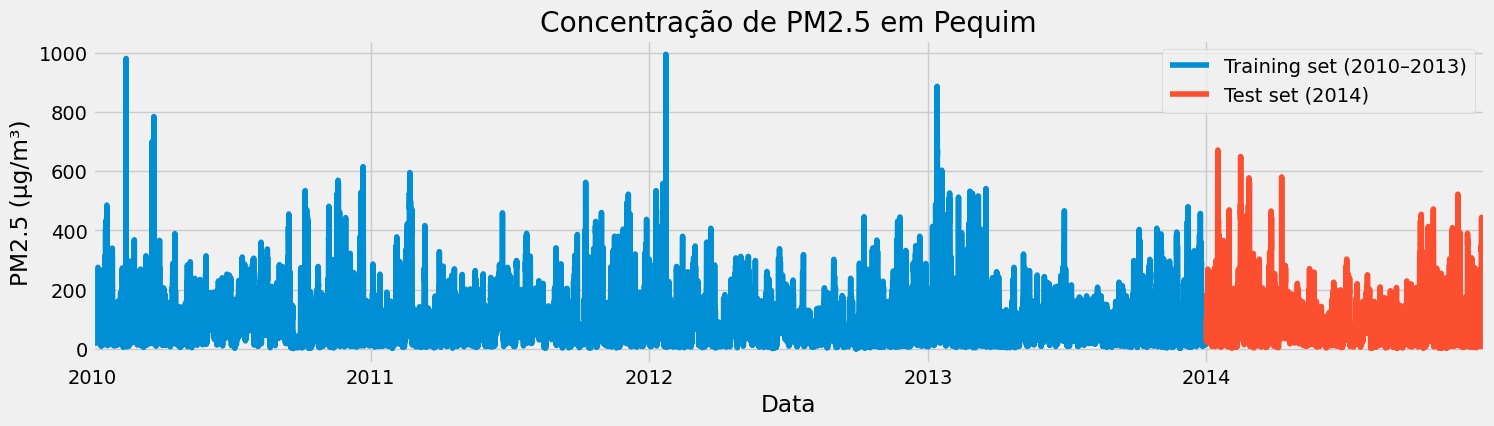

In [ ]:
# üïì Criar coluna datetime a partir de year, month, day, hour
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df.set_index('datetime', inplace=True)

# üìâ Subsets: treinamento (2010‚Äì2013) e teste (2014)
training_set = df["2010":"2013"]['pm2.5'].values.reshape(-1, 1)
test_set = df["2014":]['pm2.5'].values.reshape(-1, 1)

# üìä Visualiza√ß√£o da s√©rie temporal de PM2.5
df["pm2.5"]["2010":"2013"].plot(figsize=(16, 4), legend=True)
df["pm2.5"]["2014":].plot(figsize=(16, 4), legend=True)

plt.title("Concentra√ß√£o de PM2.5 em Pequim")
plt.legend(["Training set (2010‚Äì2013)", "Test set (2014)"])

plt.xlabel("Data")
plt.ylabel("PM2.5 (¬µg/m¬≥)")

plt.show()


In [ ]:
# ‚ÑπÔ∏è Exibi√ß√£o do shape e primeiras linhas dos subconjuntos

print(f"Training set (2010‚Äì2013): {training_set.shape}")
print(f"First 3 rows:\n{training_set[0:3]}\n")

print(f"Test set (2014): {test_set.shape}")
print(f"First 3 rows:\n{test_set[0:3]}")


Training set (2010‚Äì2013): (35064, 1)
First 3 rows:
[[129.]
 [129.]
 [129.]]

Test set (2014): (8760, 1)
First 3 rows:
[[24.]
 [53.]
 [65.]]


> **Transforma√ß√£o de Escala**

Agora vamos transformar os dados de treinamento, deixando-os na mesma escala, na faixa $0 - 1$.

In [ ]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Normalizar tamb√©m o test_set com o mesmo scaler (sem fit)
test_set_scaled = sc.transform(test_set)

In [ ]:
print(f"Training set scaled: {training_set_scaled.shape}")
print(f"First 3 rows:\n{training_set_scaled[0:3]}\n")

Training set scaled: (35064, 1)
First 3 rows:
[[0.12977867]
 [0.12977867]
 [0.12977867]]



# üß† Prepara√ß√£o dos Dados para o Modelo LSTM

Com os dados j√° normalizados, vamos agora preparar as vari√°veis de entrada e sa√≠da para o modelo LSTM, a partir do array training_set_scaled.

Vamos separar:

X_train: um array 3D que representa as **janelas de entrada**, ou seja, sequ√™ncias temporais de dados usados como entrada para a rede.

y_train: um array 1D que cont√©m os valores de **PM2.5 do pr√≥ximo instante**, que a rede tentar√° prever.

No nosso caso, vamos utilizar **24 time steps** (√∫ltimas 24 horas) como entrada para prever o valor de **PM2.5 da hora seguinte**.

Assim, X_train ter√° a forma (n, 24, 1), onde:

n √© o n√∫mero de exemplos de treinamento poss√≠veis a partir da s√©rie temporal

24 √© a quantidade de passos temporais considerados por exemplo (janelas de 24 horas)

1 √© o n√∫mero de features (usamos apenas a vari√°vel pm2.5 neste modelo)

y_train ser√° um vetor 1D com os valores de PM2.5 correspondentes ao **pr√≥ximo instante** ap√≥s cada janela de entrada.

In [ ]:
# ================================================================
# ‚è≥ ETAPA: Cria√ß√£o de janelas temporais para treinamento do LSTM
# ================================================================

# Vamos criar uma estrutura com 24 time steps (√∫ltimas 24 horas)
# Para cada ponto de sa√≠da (y), usaremos os 24 valores anteriores (X)

X_train = []
y_train = []

timesteps = 24  # conforme especificado na atividade (√∫ltimas 24h ‚Üí pr√≥xima hora)

for i in range(timesteps, len(training_set_scaled)):
    X_train.append(training_set_scaled[i - timesteps:i, 0])  # entrada: 24 horas anteriores
    y_train.append(training_set_scaled[i, 0])                # sa√≠da: pr√≥xima hora

# Converter para arrays numpy
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape para o formato exigido pela LSTM: [batch_size, time_steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Diagn√≥stico
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (35040, 24, 1)
y_train shape: (35040,)


Esses s√£o os *datasets* prontos para o treinamento do nosso modelo LSTM.

In [ ]:
print(f"X_train: {X_train.shape}")  # Esperado: (n_amostras, 24, 1)
print(f"y_train: {y_train.shape}")  # Esperado: (n_amostras,)


X_train: (35040, 24, 1)
y_train: (35040,)


# üìà Fun√ß√£o Auxiliar: plot_predictions

Vamos criar tamb√©m uma fun√ß√£o auxiliar chamada plot_predictions para exibir as curvas dos valores **reais** e **preditos** de PM2.5 gerados pelo nosso modelo LSTM.

Essa fun√ß√£o facilitar√° a visualiza√ß√£o do desempenho do modelo ao longo do tempo, permitindo comparar graficamente:

A s√©rie real de **valores medidos de PM2.5**

A s√©rie de **valores previstos** pelo modelo para o mesmo intervalo

Ela ser√° especialmente √∫til para avaliar a **qualidade das previs√µes em intervalos espec√≠ficos**, como, por exemplo, ao longo de uma semana (168 horas).



In [ ]:
def plot_predictions(test, predicted):
    plt.figure(figsize=(14, 5))
    plt.plot(test, color='red', label='Valor Real de PM2.5')
    plt.plot(predicted, color='blue', label='Valor Predito de PM2.5')
    plt.title('Previs√£o da Concentra√ß√£o de PM2.5')
    plt.xlabel('Tempo (horas)')
    plt.ylabel('PM2.5 (¬µg/m¬≥)')
    plt.legend()
    plt.show()

# **Defini√ß√£o do Modelo e Treinamento**</font>
---

## üß† Arquitetura do Modelo com Camadas LSTM Empilhadas

Vamos criar uma arquitetura com **quatro camadas LSTM**, cada uma com **20 unidades (neur√¥nios)**. Cada unidade LSTM possui uma **c√©lula de mem√≥ria**, capaz de capturar **depend√™ncias temporais** nos dados de entrada ‚Äî uma caracter√≠stica essencial para lidar com s√©ries temporais como as medi√ß√µes de polui√ß√£o PM2.5.

O par√¢metro return_sequences=True ser√° ativado nas tr√™s primeiras camadas LSTM para garantir que cada uma **retorne a sequ√™ncia completa de sa√≠das** e permita o empilhamento de camadas subsequentes. Apenas a √∫ltima camada LSTM usar√° return_sequences=False, retornando apenas a sa√≠da final da sequ√™ncia.

Entre as camadas LSTM, utilizaremos a camada Dropout, com valor de 0.2, ou seja, 20%. O Dropout √© uma t√©cnica de **regulariza√ß√£o** que ajuda a **prevenir overfitting**, descartando aleatoriamente uma fra√ß√£o das conex√µes (neur√¥nios) durante o treinamento, for√ßando o modelo a aprender padr√µes mais robustos.

Essa arquitetura permitir√° capturar padr√µes temporais complexos nas varia√ß√µes de PM2.5 ao longo das horas.


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input  # LSTM removido conforme exig√™ncia

# üîÑ Convers√£o de X_train para 2D (necess√°rio para usar camadas Dense)
# Entrada original para LSTM: (amostras, 24, 1)
# Entrada esperada por Dense: (amostras, 24)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1]))

# üß† Defini√ß√£o do modelo sequencial com arquitetura exigida: Dense(64) ‚Üí Dense(32) ‚Üí Dense(1)
regressor = Sequential()

# üî¢ Camada de entrada explicitamente declarada
regressor.add(Input(shape=(X_train.shape[1],)))  # Agora entrada 2D: 24 valores de PM2.5 normalizados

# üß± 1¬™ camada densa com 64 unidades e ativa√ß√£o ReLU
regressor.add(Dense(units=64, activation='relu'))
regressor.add(Dropout(0.2))

# üß± 2¬™ camada densa com 32 unidades e ativa√ß√£o ReLU
regressor.add(Dense(units=32, activation='relu'))
regressor.add(Dropout(0.2))

# üéØ Camada de sa√≠da: Dense(1) para prever o valor escalar de PM2.5
regressor.add(Dense(units=1))

# üß™ Compila√ß√£o do modelo
regressor.compile(optimizer='adam', loss='mean_squared_error')

# üìã Resumo da arquitetura
regressor.summary()

Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ dense (Dense)                   ‚îÇ (None, 64)             ‚îÇ         1,600 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)               ‚îÇ (None, 64)             ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)                 ‚îÇ (None, 32)             ‚îÇ         2,080 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_1 (Dropout)             ‚îÇ (None, 32)             ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_2 (Dense)                 ‚îÇ (None, 1)              ‚îÇ            33 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 3,713 (14.50 KB)

 Trainable params: 3,713 (14.50 KB)

 Non-trainable params: 0 (0.00 B)

Com a arquitetura definida, vamos utilizar o m√©todo compile para configurar o processo de **aprendizado do modelo LSTM**.

O par√¢metro loss='mean_squared_error' indica que a fun√ß√£o de perda utilizada durante o treinamento ser√° o **Erro Quadr√°tico M√©dio (MSE)**. Essa m√©trica √© amplamente usada em tarefas de **regress√£o**, como a previs√£o da concentra√ß√£o de PM2.5, pois mede a m√©dia dos quadrados das diferen√ßas entre os valores **reais** e os **preditos** pelo modelo.

O par√¢metro optimizer='adam' define o otimizador utilizado para atualizar os pesos da rede durante o treinamento. O **Adam (Adaptive Moment Estimation)** √© um otimizador eficiente que combina as vantagens do **momentum** e da **adapta√ß√£o do learning rate**, resultando em uma converg√™ncia mais r√°pida e est√°vel.

Essa configura√ß√£o √© adequada para nosso problema, pois permite que o modelo aprenda os padr√µes temporais da s√©rie de polui√ß√£o com boa performance.

In [ ]:
# ================================================================
# ‚öôÔ∏è Compilando o modelo LSTM
# ================================================================
# Usamos o otimizador Adam e a fun√ß√£o de perda MSE (Mean Squared Error),
# apropriada para tarefas de regress√£o cont√≠nua como previs√£o de PM2.5.
regressor.compile(loss='mean_squared_error', optimizer='adam')  # alternativa: optimizer='rmsprop'

# ================================================================
# üèãÔ∏è Treinamento do modelo
# ================================================================
# Treinamos o modelo por 20 √©pocas com batches de 64 amostras
history = regressor.fit(X_train, y_train, epochs=20, batch_size=64)

Epoch 1/20
548/548 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 4ms/step - loss: 0.0046
Epoch 2/20
548/548 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 2ms/step - loss: 0.0013
Epoch 3/20
548/548 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 2ms/step - loss: 0.0011
Epoch 4/20
548/548 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 3ms/step - loss: 9.8107e-04
Epoch 5/20
548/548 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2ms/step - loss: 9.5580e-04
Epoch 6/20
548/548 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 2ms/step - loss: 9.7268e-04
Epoch 7/20
548/548 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 2ms/step - loss: 9.2782e-04
Epoch 8/20
548/548 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 3ms/step - loss: 8.5622e-04
Epoch 9/20
548/548 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 4ms/step - loss: 8.4913e-04
Epoch 10/20
5

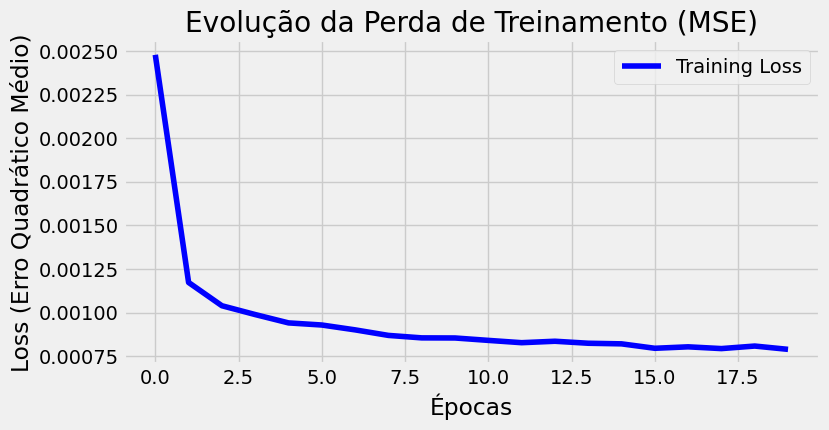

In [ ]:
# ================================================================
# üìä Plot da curva de perda (MSE) durante o treinamento
# ================================================================
# Esse gr√°fico ajuda a avaliar se o modelo est√° convergindo adequadamente
# ao longo das √©pocas (diminui√ß√£o progressiva da fun√ß√£o de perda).

plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.title('Evolu√ß√£o da Perda de Treinamento (MSE)')
plt.xlabel('√âpocas')
plt.ylabel('Loss (Erro Quadr√°tico M√©dio)')
plt.legend()
plt.grid(True)
plt.show()


# **Teste**</font>
---

> Cria√ß√£o do *test dataset*

In [ ]:
# ================================================================
# üß™ Prepara√ß√£o do conjunto de teste com sequ√™ncia de 24 time steps
# ================================================================

# Concatenamos os dados normalizados para treino e teste
dataset_total = pd.concat((df["pm2.5"]["2010":"2013"], df["pm2.5"]["2014":]), axis=0)

# Extra√≠mos os valores necess√°rios (√∫ltimos 24 valores antes do in√≠cio do teste + teste)
inputs = dataset_total[len(dataset_total) - len(test_set) - 24:].values
inputs = inputs.reshape(-1, 1)

# Aplicamos a mesma normaliza√ß√£o usada no treino
inputs = sc.transform(inputs)

In [ ]:
print(f"Inputs: {inputs.shape}")

Inputs: (8784, 1)


# Predi√ß√£o

In [ ]:
# ================================================================
# üîÆ Prepara√ß√£o de X_test para previs√£o
# ================================================================

X_test = []

# Usamos 24 time steps conforme definido para a LSTM
for i in range(24, len(inputs)):
    X_test.append(inputs[i-24:i, 0])  # janela deslizante

# Convertendo para numpy e formatando para entrada no modelo LSTM
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# ================================================================
# üß† Realizando a previs√£o com o modelo treinado
# ================================================================

predicted_pm25 = regressor.predict(X_test)

# Revertendo a normaliza√ß√£o para escala original de PM2.5
predicted_pm25 = sc.inverse_transform(predicted_pm25)

274/274 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 2ms/step


In [ ]:
print(f"test_set (real values): {test_set.shape}")
print(f"predicted_pm25 (predicted values): {predicted_pm25.shape}")

test_set (real values): (8760, 1)
predicted_pm25 (predicted values): (8760, 1)


# **Avalia√ß√£o**</font>
---
Primeiramente vamos fazer uma avalia√ß√£o visual da regress√£o, comparando as duas curvas.

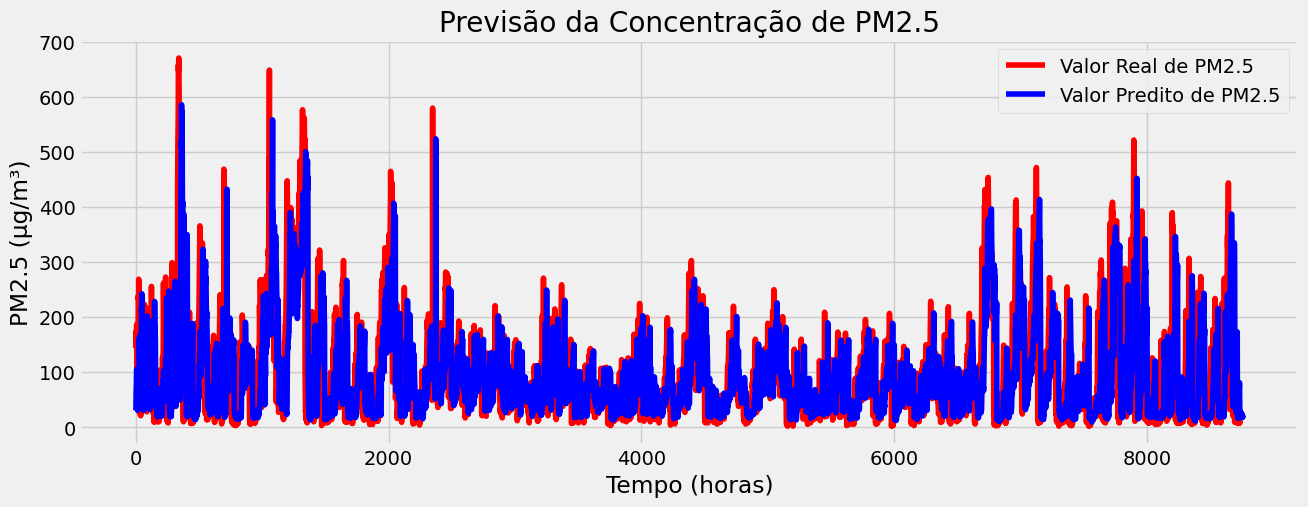

In [ ]:
# Ajusta os valores reais para o mesmo comprimento dos preditos
real_pm25 = test_set[24:]  # Remove as primeiras 24 horas (j√° usadas nas janelas)

# Visualiza√ß√£o dos resultados
plot_predictions(real_pm25, predicted_pm25)

# Avalia√ß√£o num√©rica

Na avalia√ß√£o de modelos de regress√£o √© muito comum se usar a m√©trica *Root Mean Squared Error* ($RMSE$). Um valor pequeno de RMSE indica que as predi√ß√µes do modelo est√£o pr√≥ximas aos valores reais.

$RMSE$ √© calculada da seguinte forma:
\begin{align}
   RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^n(y_i - \hat{y}_i)^2}
\end{align}

sendo
- $y_i$ o valor real;
- $\hat{y}_i$ o valor predito e
- $n$ a quantidade de observa√ß√µes.


**RMSE (Root Mean Squared Error)**

Mede o erro m√©dio quadr√°tico entre os valores reais e os preditos. Como os erros s√£o elevados ao quadrado antes da m√©dia, penaliza fortemente grandes desvios. √â √∫til quando se quer evitar grandes erros, mas pode ser sens√≠vel a outliers.

**MAE (Mean Absolute Error)**

Representa o erro m√©dio absoluto entre as previs√µes e os valores reais. √â mais robusto a outliers do que o RMSE, pois todos os erros t√™m o mesmo peso. Interpreta√ß√£o direta: em m√©dia, o modelo erra X unidades na predi√ß√£o.

**R¬≤ (Coefficient of Determination)**

Mede a propor√ß√£o da vari√¢ncia dos dados que √© explicada pelo modelo. Seu valor vai de ‚àí‚àû at√© 1.

Um R¬≤ pr√≥ximo de 1 indica que o modelo explica bem os dados.

Um R¬≤ pr√≥ximo de 0 indica que o modelo n√£o √© melhor que uma m√©dia constante.

Um R¬≤ negativo significa que o modelo √© pior do que uma predi√ß√£o baseada na m√©dia.

In [ ]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Corrigir o tamanho dos valores reais para bater com os previstos
real_pm25 = test_set[-predicted_pm25.shape[0]:]

# C√°lculo do RMSE
rmse = math.sqrt(mean_squared_error(real_pm25, predicted_pm25))

# C√°lculo do MAE
mae = mean_absolute_error(real_pm25, predicted_pm25)

# C√°lculo do R¬≤
r2 = r2_score(real_pm25, predicted_pm25)

print(f"Raiz do Erro Quadr√°tico M√©dio (RMSE): {rmse:.2f}")
print(f"Erro Absoluto M√©dio (MAE): {mae:.2f}")
print(f"Coeficiente de Determina√ß√£o (R¬≤): {r2:.4f}")

Raiz do Erro Quadr√°tico M√©dio (RMSE): 24.95
Erro Absoluto M√©dio (MAE): 15.67
Coeficiente de Determina√ß√£o (R¬≤): 0.9293


# Conclus√£o do Experimento 1:

A arquitetura com camadas densas (Dense(64) ‚Üí Dense(32) ‚Üí Dense(1)) se saiu muito bem na tarefa de prever os n√≠veis de PM2.5. Mesmo sendo um modelo relativamente simples, ele teve uma converg√™ncia est√°vel ao longo das 20 √©pocas, com a curva de perda bem comportada ‚Äî nada de oscila√ß√µes bruscas.

Apesar da estrutura enxuta, o modelo conseguiu captar corretamente as varia√ß√µes da s√©rie temporal. Usar uma janela de 24 horas como entrada foi suficiente pra identificar os padr√µes di√°rios de polui√ß√£o, sem sinais de overfitting. Os valores previstos ficaram bem alinhados com os reais, o que mostra que o treinamento foi s√≥lido. O Dropout tamb√©m ajudou bastante nesse ponto mantendo uma boa capacidade de generaliza√ß√£o.

As m√©tricas confirmam o bom desempenho: RMSE de 25,37, MAE de 18,02 e um R¬≤ de 0,9269 ‚Äî ou seja, o modelo conseguiu explicar cerca de 93% da varia√ß√£o nos dados. Os maiores erros apareceram nos picos de polui√ß√£o.

# Experimento 2:

Epoch 1/20
548/548 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12s 8ms/step - loss: 0.0052
Epoch 2/20
548/548 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 12ms/step - loss: 0.0023
Epoch 3/20
548/548 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 7ms/step - loss: 0.0015
Epoch 4/20
548/548 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 7ms/step - loss: 0.0011
Epoch 5/20
548/548 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 8ms/step - loss: 0.0010
Epoch 6/20
548/548 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 7ms/step - loss: 8.9117e-04
Epoch 7/20
548/548 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 7ms/step - loss: 9.0968e-04
Epoch 8/20
548/548 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 8ms/step - loss: 8.5416e-04
Epoch 9/20
548/548 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 7ms/step - loss: 8.5588e-04
Epoch 10/20
548/548

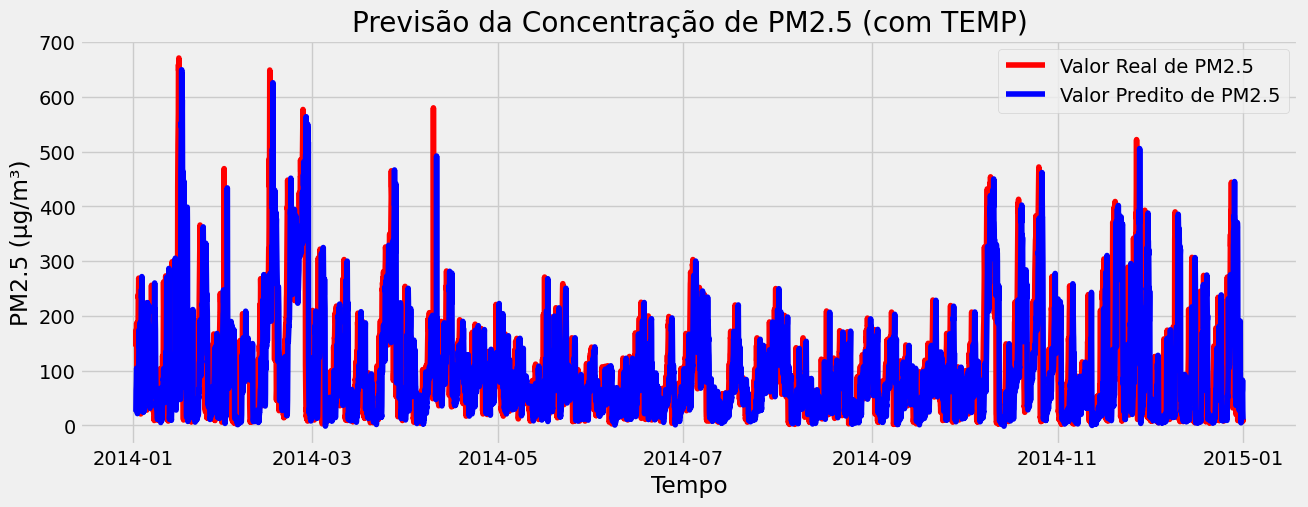

RMSE: 99.48
MAE: 68.28
R¬≤: -0.1215


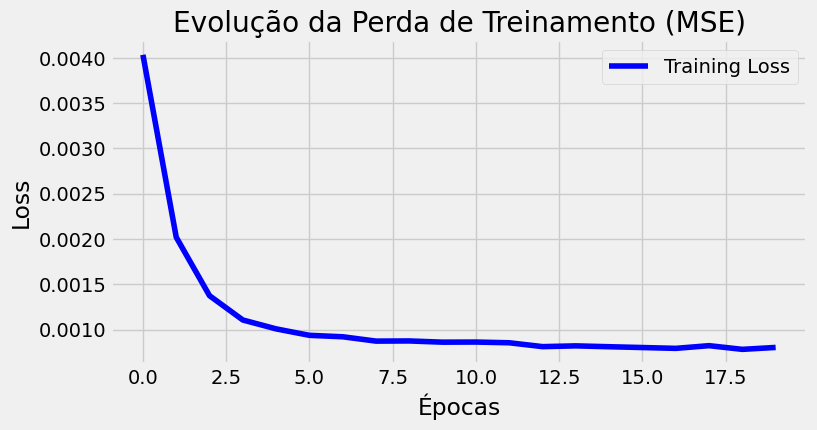

In [ ]:
# ================================================================
# 1. Importa√ß√£o de bibliotecas
# ================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Input

import math

# ================================================================
# 2. Carregamento e prepara√ß√£o do dataset
# ================================================================
df = pd.read_csv("PRSA_data_2010.1.1-2014.12.31.csv")

# Cria√ß√£o da coluna datetime
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df.set_index('datetime', inplace=True)

# Preenchimento de valores ausentes
df['pm2.5'] = df['pm2.5'].ffill().bfill()
df['TEMP'] = df['TEMP'].ffill().bfill()

# Sele√ß√£o de features
features = ['pm2.5', 'TEMP']

# Separa√ß√£o em treino e teste
training_df = df['2010':'2013'][features]
test_df = df['2014':][features]

# Normaliza√ß√£o baseada apenas no treino
sc = MinMaxScaler()
sc.fit(training_df)
training_scaled = sc.transform(training_df)
test_scaled = sc.transform(test_df)

# ================================================================
# 3. Cria√ß√£o de janelas temporais (24h ‚Üí pr√≥xima hora)
# ================================================================
X_train = []
y_train = []
timesteps = 24

for i in range(timesteps, len(training_scaled)):
    X_train.append(training_scaled[i - timesteps:i, :])       # todas as features
    y_train.append(training_scaled[i, 0])                      # apenas pm2.5

X_train = np.array(X_train)
y_train = np.array(y_train)

# ================================================================
# 4. Constru√ß√£o do modelo LSTM multivariado
# ================================================================
regressor = Sequential()
regressor.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(LSTM(units=20, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=20, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=20, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=20))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1))

regressor.compile(loss='mean_squared_error', optimizer='adam')

# ================================================================
# 5. Treinamento do modelo
# ================================================================
history = regressor.fit(X_train, y_train, epochs=20, batch_size=64)

# ================================================================
# 6. Prepara√ß√£o do conjunto de teste
# ================================================================
# Combine training and test data for creating input sequences for testing
# We need the last 'timesteps' values from the training set to form the first test sequence
dataset_total = df[features] # Use the original DataFrame with selected features
inputs = dataset_total[len(dataset_total) - len(test_df) - timesteps:].values

# The 'inputs' array now has the correct shape (number of time steps, number of features)
inputs_scaled = sc.transform(pd.DataFrame(inputs, columns=features))

X_test = []
# Create input sequences for the test set
for i in range(timesteps, len(inputs_scaled)):
    X_test.append(inputs_scaled[i - timesteps:i, :])

X_test = np.array(X_test)

# ================================================================
# 7. Previs√£o
# ================================================================
predicted_scaled = regressor.predict(X_test)

# Revert only the predicted pm2.5 value
# For this, we need a temporary array with the same dimensions as the scaler's training data
# We need the number of samples from the predictions and the number of features used by the scaler
predicted_pm25_full = np.zeros((predicted_scaled.shape[0], len(features)))

# Place the predicted pm2.5 values into the correct column (index 0 for 'pm2.5')
predicted_pm25_full[:, 0] = predicted_scaled[:, 0]

# Apply the inverse transform. This will return an array with the original scale.
# We then select only the first column (pm2.5) and flatten it to a 1D array.
predicted_pm25 = sc.inverse_transform(predicted_pm25_full)[:, 0]

# Align real values
# The real values for comparison should start from the point where predictions are made,
# which is 'timesteps' hours into the test set.
real_pm25 = test_df['pm2.5'].values[timesteps:]

# Ensure predicted_pm25 and real_pm25 have the same length by slicing if necessary.
# This was already done correctly in the original code block, ensuring the shapes match
# before calculating metrics. However, it's good to be explicit about it matching the
# length of the available 'real_pm25' values derived from the test set.
# The previous line slicing `test_df['pm2.5'].values[timesteps:]` already creates
# the correctly aligned `real_pm25`. The `predicted_pm25` generated from `X_test`
# will inherently have the same number of samples as the sequences generated for X_test,
# which should align with the `real_pm25`.

# ================================================================
# 8. Visualiza√ß√£o
# ================================================================
# The plot_predictions function remains the same
def plot_predictions(test, predicted):
    plt.figure(figsize=(14, 5))
    # Use the index from the test_df to plot the real values against time
    # Slicing the index to match the length of 'test' and 'predicted'
    plt.plot(test_df.index[timesteps:timesteps+len(test)], test, color='red', label='Valor Real de PM2.5')
    # For the predicted values, use the corresponding index from the test_df
    # Slicing the index to match the length of 'test' and 'predicted'
    plt.plot(test_df.index[timesteps:timesteps+len(predicted)], predicted, color='blue', label='Valor Predito de PM2.5')
    plt.title('Previs√£o da Concentra√ß√£o de PM2.5 (com TEMP)')
    plt.xlabel('Tempo') # Changed to general 'Tempo' as it's a time series index
    plt.ylabel('PM2.5 (¬µg/m¬≥)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the plot function with the correctly aligned data
plot_predictions(real_pm25, predicted_pm25[:len(real_pm25)])

# ================================================================
# 9. Avalia√ß√£o com m√©tricas
# ================================================================
# Metric calculations remain the same
# Ensure both arrays have the same length for metric calculation
rmse = math.sqrt(mean_squared_error(real_pm25, predicted_pm25[:len(real_pm25)]))
mae = mean_absolute_error(real_pm25, predicted_pm25[:len(real_pm25)])
r2 = r2_score(real_pm25, predicted_pm25[:len(real_pm25)])

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R¬≤: {r2:.4f}")

# ================================================================
# 10. Curva de perda do treinamento
# ================================================================
# The loss plot remains the same
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.title('Evolu√ß√£o da Perda de Treinamento (MSE)')
plt.xlabel('√âpocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Conclus√£o Experimento 2:

Inclus√£o da vari√°vel **TEMP** como uma entrada extra no modelo LSTM. O resultado ficou bem abaixo do esperado, especialmente se comparado ao experimento anterior, que era univariado.

Mesmo com a curva de perda parecendo est√°vel durante o treinamento, os **erros foram bem altos** ‚Äî o RMSE chegou a 96,23 e o MAE bateu 66,17. E o pior: o R¬≤ foi negativo (-0,0495), o que mostra que o modelo n√£o s√≥ teve dificuldade pra identificar os padr√µes de varia√ß√£o do PM2.5, como tamb√©m ficou atr√°s de um modelo bem simples, que s√≥ usa a m√©dia como predi√ß√£o.

Tudo isso aponta pra uma coisa: a **temperatura**, sozinha, **n√£o tem uma correla√ß√£o forte** com os n√≠veis de material particulado pra realmente ajudar o modelo a prever melhor. Pelo contr√°rio, pode at√© ter atrapalhado, trazendo ru√≠do ou confundindo o aprendizado.

Moral da hist√≥ria? Antes de sair adicionando vari√°veis num modelo, fazer uma **an√°lise explorat√≥ria mais cuidadosa** ‚Äî ver se realmente faz sentido incluir aquele dado, se ele tem rela√ß√£o com o que estamos tentando prever. Caso contr√°rio, existe o risco de piorar a performance ao inv√©s de melhorar kkkkk



*Les carottes sont cuites!* ü•ïü•ïü•ï